In [ ]:
!pip install swig
!pip install "gymnasium[box2d]"
!pip install -q renderlab

In [ ]:
import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
import gymnasium as gym
from pathlib import Path

In [ ]:
def set_seed(seed: int) -> None:
  """set random seeds in all libs used"""
  torch.manual_seed(seed)
  np.random.seed(seed)

set_seed(42)

In [ ]:
ENV_NAME = "LunarLander-v3"

In [ ]:
# Hyperparameters
GAMMA = 0.99
LR = 1e-3
EPISODES = 200
SAVE_PATH = './checkpoints/reinforce.pth'

In [ ]:
class PolicyNetwork(nn.Module):
  """policy network"""
  def __init__(self, n_obs: int, n_act: int, n_hidden: int = 128) -> None:
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_obs, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_act)
    )

  def forward(self, x: Tensor) -> Tensor:
    """return action logits"""
    return self.net(x)

In [ ]:
class ReinforceAgent:
  """class for reinforce agent"""
  def __init__(self, n_obs: int, n_act: int):
    self.policy = PolicyNetwork(n_obs, n_act)
    self.optimizer = torch.optim.AdamW(self.policy.parameters(), lr=LR)

  def select_action(self, state: np.ndarray) -> tuple[int, Tensor]:
    """
    select action based on current policy
    returns: sampled action with its log prob
    """
    logits = self.policy(torch.from_numpy(state).type(torch.float32).unsqueeze(dim=0))
    probs = nn.functional.softmax(logits, dim=1)
    m = torch.distributions.Categorical(probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

  def compute_returns(self, rewards: list[float]) -> Tensor:
    """Compute discounted returns for the given rewards at each timestamp"""
    G = 0.0
    returns: list[float] = []
    for r in reversed(rewards):
      G = r + GAMMA * G
      returns.insert(0, G)

    returns_tensor = torch.tensor(returns, dtype=torch.float32)
    returns_tensor = (returns_tensor - returns_tensor.mean()) / (returns_tensor.std() + 1e-9)
    return returns_tensor

  def update_policy(self, log_probs: Tensor, returns: Tensor) -> None:
    policy_loss = [-log_prob * R for log_prob, R in zip(log_probs, returns)]
    loss = sum(policy_loss)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def save_policy(self) -> None:
    """save current policy network"""
    path = Path(SAVE_PATH)
    path.parent.mkdir(parents=True, exist_ok=True)
    torch.save(self.policy.state_dict(), f=path)
    print(f"saved model to {path}")

  def load_policy(self) -> None:
    """load policy"""
    path = Path(SAVE_PATH)
    if not path.exists():
      print(f"no model found at {path}")
    else:
      self.policy.load_state_dict(torch.load(path))
      print(f"model loaded from {path}")

In [ ]:
env = gym.make(ENV_NAME)
n_obs = env.observation_space.shape[0]
n_act = env.action_space.n

agent = ReinforceAgent(n_obs, n_act)
agent.load_policy()

rewards_history = []

for episode in range(EPISODES):
  state, _ = env.reset()
  done = False
  rewards: list[float] = []
  log_probs: list[Tensor] = []

  while not done:
    action, log_prob = agent.select_action(state)
    next_state, reward, done, _, _ = env.step(action)
    log_probs.append(log_prob)
    rewards.append(reward)
    state = next_state

  log_probs = torch.cat(log_probs)
  returns = agent.compute_returns(rewards)
  agent.update_policy(log_probs, returns)

  total_reward = sum(rewards)
  rewards_history.append(total_reward)

  if episode % 20 == 0:
    print(f"Episode: {episode}, Total reward: {total_reward}")

env.close()
agent.save_policy()

model loaded from checkpoints/reinforce.pth
Episode: 0, Total reward: -45.93276873352677
Episode: 20, Total reward: -65.57367062945181
Episode: 40, Total reward: -176.43795744344675
Episode: 60, Total reward: -35.5045035336873
Episode: 80, Total reward: -292.4962568976118
Episode: 100, Total reward: -159.3840885619406
Episode: 120, Total reward: -141.98197155646287
Episode: 140, Total reward: -102.64832550955612
Episode: 160, Total reward: -121.6185077529773
Episode: 180, Total reward: -87.30569591796227
saved model to checkpoints/reinforce.pth


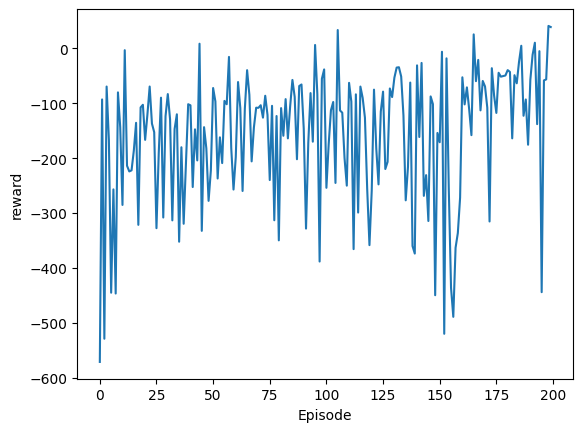

In [ ]:
import matplotlib.pyplot as plt

plt.plot(rewards_history)
plt.xlabel("Episode")
plt.ylabel("reward")
plt.show()

In [ ]:
import renderlab as rl

eval_env = gym.make(ENV_NAME, render_mode="rgb_array")
eval_env = rl.RenderFrame(eval_env, "./output")

n_obs = eval_env.observation_space.shape[0]
n_act = eval_env.action_space.n

agent = ReinforceAgent(n_obs, n_act)
agent.load_policy()

state, _ = eval_env.reset()
done = False
rewards = []

while not done:
  action, log_prob = agent.select_action(state)
  state, reward, done, _, _ = eval_env.step(action)
  rewards.append(reward)

eval_env.render()
eval_env.close()
eval_env.play()  # Play rendered frames directly in Colab

model loaded from checkpoints/reinforce.pth
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4
